# Mixed neural likelihood estimation of reaction time, movement time, and choice

This Notebook show the optimization/fitting pipeline used to fit the model to the data in the paper:
<i>Rapid, systematic updating of movement by accumulated decision evidence</i>
[Molano-Mazón et al. 2024 Nature Communications](https://www.biorxiv.org/content/10.1101/2023.11.09.566389v2). The pipeline uses the [SBI  toolbox](https://joss.theoj.org/papers/10.21105/joss.02505). More specifically, it uses mixed neural likelihood estimation (MNLE) developed by [Boelts et al. 2022](https://elifesciences.org/articles/77220). The model is described in the main text. 


## Import libraries

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
from sbi.inference import MNLE
from sbi.utils import MultipleIndependent
import torch
from torch.distributions import Uniform
import matplotlib.pylab as pl
import time
from pybads import BADS
import warnings
import os
import logging
warnings.filterwarnings('ignore')
PYTENSOR_FLAGS=''
logging.getLogger('matplotlib.font_manager').disabled = True

# append the path of the python scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\scripts")

# import custom functions
from extended_ddm_v2 import get_data_and_matrix
from optimization import simulations_for_mnle, prepare_fb_data

# setting manual seeds
np.random.seed(0)
torch.manual_seed(0)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
DATA_FOLDER = '...'  # path where rat data is placed

SV_FOLDER = '...'  # path where to save things


## Load data

First, we load the data from a certain rat or human. In this case we will use a rat, ``LE43``. We extract the important vairables, movement and reaction times (MT, RT), choice, stimulus, prior and trial index.

In [3]:
# load real data
subject = 'LE43'
df = get_data_and_matrix(dfpath=DATA_FOLDER + subject, return_df=True, after_correct=True, silent=True, all_trials=True,
                         srfail=True)  # load data frame
mt = df.resp_len.values  # movement time
choice = df.R_response.values  # choice
zt = np.nansum(df[["dW_lat", "dW_trans"]].values, axis=1)  # prior evidence
stim = np.array([stim for stim in df.res_sound])  # stimulus
coh = np.array(df.coh2)  # putative stimulus
trial_index = np.array(df.origidx)  # trial index
rt = df.sound_len.values  # reaction time
print('Ended loading data')

Loading data
Ended loading data


## Build priors


We will now build the prior distributions for the parameters of the model. For simplicity, we defined uniform distributions for all parameters. Note that the broader these distributions are the harder will be to approximate the likelihood.

In [4]:
# 1. Parameters' prior distro definition (bounds must be float!)
prior = MultipleIndependent([Uniform(torch.tensor([1e-1]),
                                     torch.tensor([1])),  # prior weight
                             Uniform(torch.tensor([1e-3]),
                                     torch.tensor([0.8])),  # stim weight
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([3.])),  # evidence integrator bound
                             Uniform(torch.tensor([1e-8]),
                                     torch.tensor([1.])),  # CoM bound
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # afferent time
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # efferent time
                             Uniform(torch.tensor([9.]),
                                     torch.tensor([16.])),  # time offset action
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([0.08])),  # intercept trial index for action drift
                             Uniform(torch.tensor([1e-7]),
                                     torch.tensor([5e-6])),  # slope trial index for action drift
                             Uniform(torch.tensor([1.]),
                                     torch.tensor([4.])),  # bound for action integrator
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at first readout (for MT reduction)
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at second readout
                             Uniform(torch.tensor([0.2]),
                                     torch.tensor([0.9])),  # leak
                             Uniform(torch.tensor([1.]),
                                     torch.tensor([35.])),  # std of the MT noise
                             Uniform(torch.tensor([120.]),
                                     torch.tensor([400.])),  # MT offset
                             Uniform(torch.tensor([0.06]),
                                     torch.tensor([0.5]))],  # MT slope with trial index
                            validate_args=False)



Now we can use the function ``sample`` with an argument that indicates the number of simulations ``num_simulations`` used to train the network: ``prior.sample((num_simulations,))``.
### Caution!
Note that the higher this number is, the longer it will take to simulate and train. For instance, for 10K, the training takes about 4 min, for 100K simulations, it takes ~2h.

Since the training is sensitive to the prior distribution sample (especially if the sample size is small), we fixed a seed at the beginning of the notebook to ensure reproducibility.

In [5]:
# 2. define parameter space with samples from prior
num_simulations = 100_000
theta_all = prior.sample((num_simulations,))



We can plot the prior distributions, although they are all uniform.

In [6]:
labels = ['prior weight', 'stim weight', 'EA bound', 'CoM bound', 't aff', 't eff', 'tAction', 'intercept AI', 'slope AI',
          'AI bound', 'DV weight 1st readout', 'DV weight 2nd readout', 'leak', 'MT noise std', 'MT offset', 'MT slope T.I.']
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16,16))
ax = ax.flatten()
for iax in range(len(ax)):
    sns.histplot(theta_all[:, iax], ax=ax[iax])
    ax[iax].set_xlabel(labels[iax])
plt.show()
fig.tight_layout()

## Simulations

We now proceed to simulate 100_000 <b>different trials</b> (one for each different combination of parameters extracted from the prior distro). The function ```simulation``` simulates the model and returns a tensor with three columns: Motor Time, Reaction Time & Choice.

In [7]:
# Prepare data:
coh = np.resize(coh, num_simulations)
zt = np.resize(zt, num_simulations)
trial_index = np.resize(trial_index, num_simulations)
stim = np.resize(stim, (num_simulations, 20))
choice = np.resize(choice, num_simulations)
mt = np.resize(mt, num_simulations)
rt = np.resize(rt, num_simulations)

In [8]:
# run simulations
x = simulations_for_mnle(theta_all, stim, zt, coh, trial_index, simulate=True)

Starting simulation
Simulation number: 100000
Time elapsed: 2.934229576587677 mins


In [9]:
# lets define a function to plot a psychometric curve considering prior bins
def psychometric(ax, choice, coh, zt_min=-1, zt_max=1, color='k'):
    coh_vals = np.sort(np.unique(coh))
    psych_vals = [np.mean(choice[(coh == coh_val) * (zt >= zt_min) * (zt < zt_max)]) for coh_val in coh_vals]
    ax.plot(coh_vals, psych_vals, marker='o', color=color, label=round(np.mean((zt_min, zt_max)), 1))

# full plot
def full_psychometric_plot(choice, coh, zt, ax=None, leg=False):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(4, 3))
    zt_bins = np.linspace(-1, 1, 8)
    colors = pl.cm.copper(np.linspace(0., 1, len(zt_bins)-1))
    [psychometric(ax, choice, coh, zt_min=zt_bins[i_zt], zt_max=zt_bins[i_zt+1], color=colors[i_zt]) for i_zt in reversed(range(len(zt_bins)-1))]
    ax.set_xlabel('Stimulus evidence')
    ax.set_ylabel('P(right response)')
    if leg:
        ax.legend(title='Prior evidence', bbox_to_anchor=(-0.4, 0.8), fontsize=9, frameon=False)
        

We can plot the psychometric curves of the simulated data, altogether with the RT and MT distributions.

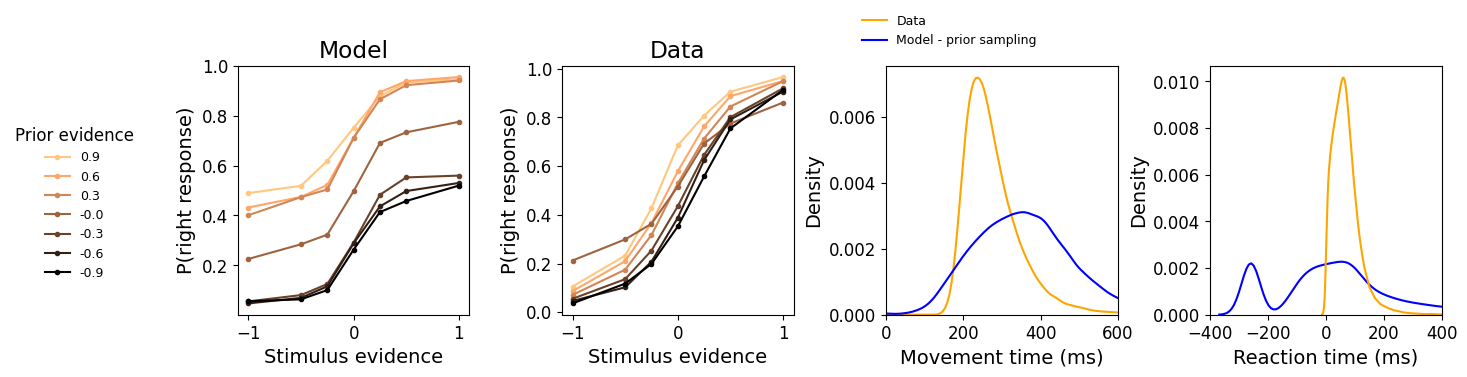

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 3))
ax = ax.flatten()
full_psychometric_plot(choice=x[:, 2].detach().numpy(), coh=coh, zt=zt, ax=ax[0], leg=True)  # model psychommetric curves
full_psychometric_plot(choice=choice, coh=coh, zt=zt, ax=ax[1])  # data psychommetric curves
# plot MT
sns.kdeplot(mt*1e3, color='orange', ax=ax[2], label='Data')  # model
sns.kdeplot(x[:,0], color='blue', ax=ax[2], label='Model - prior sampling')  # data
# plot RT
sns.kdeplot(x[:,1]-300, color='blue', ax=ax[3], label='Model - prior sampling')  # model, subtracting fixation time (300 ms)
sns.kdeplot(rt, color='orange', ax=ax[3], label='Data')  # data (with FB)
# tune panels
ax[0].set_title('Model')
ax[1].set_title('Data')
ax[2].legend(bbox_to_anchor=(0.7, 1.25), fontsize=9, frameon=False)
ax[2].set_xlim(0, 600)
ax[2].set_xlabel('Movement time (ms)')
ax[3].set_xlabel('Reaction time (ms)')
ax[3].set_xlim(-400, 400)
plt.subplots_adjust(top=0.95, bottom=0.12, left=0.09, right=0.95, hspace=0.4, wspace=0.4)

## Network training

### Data preparation


Once we have all the simulated data, we can train the network that will provide the approximated likelihood of the data for each parameter configuration. The inputs to the networks are 19: 16 parameters and 3 experimental conditions (stimulus (``coh``), prior (``zt``) and trial index (``trial_index``) for each trial). However, we can reduce this number by multiplying the prior weight and the stimulus drift by the prior (``zt``) and stimulus (``coh``), respectively:

``theta_all_inp[:, 0] *= torch.tensor(zt[:num_simulations]).to(torch.float32)``

``theta_all_inp[:, 1] *= torch.tensor(coh[:num_simulations]).to(torch.float32)``

And including the trial index in the corresponding linear equations for both the AI and the MT. With that, we get

MT_in = MT_0 + MT_1*trial_index

``theta_all_inp[:, 14] += theta_all_inp[:, 15]*trial_index_tensor``

V_A = vA_0 - vA_1*trial_index    (vA_1 is positive)


``theta_all_inp[:, 7] -= theta_all_inp[:, 8]*trial_index_tensor``


We have transformed 6 parameters and 3 experimental condtions into 4 inputs. Therefore, we reduce by 5 the length of the input vector.

In [11]:
nan_mask = torch.sum(torch.isnan(x), axis=1).to(torch.bool)
theta_all_inp = theta_all.clone().detach()
theta_all_inp[:, 0] *= torch.tensor(zt[:num_simulations]).to(torch.float32)
theta_all_inp[:, 1] *= torch.tensor(coh[:num_simulations]).to(torch.float32)
trial_index_tensor = torch.tensor(trial_index[:num_simulations].astype(float)).to(torch.float32)
theta_all_inp = theta_all_inp.to(torch.float32)
# transform parameters related to trial index. 14 params instead of 16
# MT_in = MT_0 + MT_1*trial_index
theta_all_inp[:, 14] += theta_all_inp[:, 15]*trial_index_tensor
# V_A = vA_0 - vA_1*trial_index
theta_all_inp[:, 7] -= theta_all_inp[:, 8]*trial_index_tensor
theta_all_inp = torch.column_stack((theta_all_inp[:, :8],
                                    theta_all_inp[:, 9:-1]))

### Train

We now define the trainer ``trainer = MNLE()``, and use ``append_simulations(theta, x)`` to link the simulations to it. Finally, we call the function ``train()``.

In [12]:
time_start = time.time()
trainer = MNLE(prior=prior)
estimator = trainer.append_simulations(theta_all_inp[~nan_mask, :],
                                       x[~nan_mask, :]).train(show_train_summary=True)
print('For a batch of ' + str(num_simulations) + ' simulations, it took ' + str(round(int(time.time() - time_start)/60, 3)) + ' mins')

 Neural network successfully converged after 123 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 123
        Best validation performance: 9.6795
        -------------------------
        
For a batch of 100000 simulations, it took 28.033 mins


## Maximum likelihood estimation

### Functions

Once we have trained the network, we can use ```PyBADS``` to find the Maximum Likelihood Estimate (MLE). We will work with the negative log likelihood function $NLLH$. The optimization algorithm will find the parameters that minimize the $NLLH$. 

We first define the necessary functions. Among them, the most relevant is the negative log-likelihood function, which is a piecewise function depending on $RT$: if $RT$ is positive, the likelihood is the one provided by the MNLE; otherwise, it is the distribution of the first passage time of the Action Initiation process, which is an inverse Gaussian. Therfore:


$NLLH(choice, RT, MT| \theta) =
\begin{cases}
                               NLLH_{MNLE}(choice_i, RT_i, MT_i| \theta ) & \text{if } RT_i > 0 \\
                               NLLH_{AI}(RT_i | \theta ) & \text{if } RT_i < 0
\end{cases}$


where $NNLH_{AI}(RT | \theta ) = -\sum_i^N log(p(RT_i | \theta))$, and $p(RT_i | \theta)$ is the inverse Gaussian or Wald distribution. We also added contaminant responses.


In [13]:
# uniformly distributed contaminants for joint distro of choice, reaction time (RT) and movement time (MT), for RT > 0
CTE = 1/2 * 1/600 * 1/995
# uniformly distributed contaminants for distro of RT for RT < 0
CTE_FB = 1/300

def prob_rt_fb_action(t, v_a, t_a, bound_a):  #inverse Gaussian
    # returns p(RT | theta) for RT < 0
    return (bound_a / np.sqrt(2*np.pi*(t - t_a)**3)) *\
        np.exp(- ((v_a**2)*((t-t_a) - bound_a/v_a)**2)/(2*(t-t_a)))


def get_log_likelihood_fb_psiam(rt_fb, theta_fb, eps, dt=5e-3):
    # returns - \sum LLH ( RT | theta ) for RT < 0, i.e. NLLH_AI(RT | theta)
    v_a = -theta_fb[:, 8]*theta_fb[:, -1] + theta_fb[:, 7]  # v_a = b_o - b_1*t_index
    v_a = v_a.detach().numpy()/dt
    bound_a = theta_fb[:, 9].detach().numpy()
    t_a = dt*(theta_fb[:, 6] + theta_fb[:, 5]).detach().numpy()
    t = rt_fb*1e-3
    prob = prob_rt_fb_action(t=t, v_a=v_a, t_a=t_a, bound_a=bound_a)  # compute prob(RT | theta)
    prob[np.isnan(prob)] = 0
    # apply contaminants, log and sum to return - \sum LLH ( RT | theta )
    return -np.nansum(np.log(prob*(1-eps) + eps*CTE_FB))


def fun_theta(theta, data, estimator, n_trials, eps=1e-3):  # negative log likelihood
    # returns - \sum LLH ( choice, RT, MT | theta ) for all RT, i.e. NLLH_MNLE(choice, RT, MT | theta)
    zt = data[:, 0]
    coh = data[:, 1]
    trial_index = data[:, 2]
    x_o = data[:, 3::]  # contains MT, RT, choice of data
    theta = torch.reshape(torch.tensor(theta),
                          (1, len(theta))).to(torch.float32)
    theta = theta.repeat(n_trials, 1)
    theta[:, 0] *= torch.tensor(zt[:n_trials])
    theta[:, 1] *= torch.tensor(coh[:n_trials])
    t_i = torch.tensor(
        trial_index[:n_trials]).to(torch.float32)
    theta = torch.column_stack((theta, t_i))
    x_o = x_o[:n_trials].detach().numpy()
    # trials with RT >= 0
    # we have to pass the same parameters as for the training (14 columns)
    # first, we filter the data and theta to get the indices where RT > 0, i.e. the rows where there are no NaNs in x_o
    x_o_no_fb = torch.tensor(
        x_o[np.isnan(x_o).sum(axis=1) == 0, :]).to(torch.float32)
    theta_no_fb = torch.tensor(
        theta.detach().numpy()[np.isnan(x_o).sum(axis=1) == 0, :]).to(torch.float32)
    # transform parameters related to trial index. 14 params instead of 16
    # MT_in = MT_0 + MT_1*trial_index
    theta_no_fb[:, 14] += theta_no_fb[:, 15]*theta_no_fb[:, -1]
    # V_A = vA_0 - vA_1*trial_index
    theta_no_fb[:, 7] -= theta_no_fb[:, 8]*theta_no_fb[:, -1]
    theta_no_fb = torch.column_stack((theta_no_fb[:, :8],
                                      theta_no_fb[:, 9:15]))
    x_o_no_fb = x_o_no_fb.reshape((1, x_o_no_fb.shape[0], x_o_no_fb.shape[1]))
    log_liks = estimator.log_prob(x_o_no_fb, condition=theta_no_fb).detach().numpy()  #take log prob from MNLE
    log_liks = np.exp(log_liks)*(1-eps) + eps*CTE  # add contaminants
    log_liks = np.log(log_liks)  # take log prob
    log_liks_no_fb = -np.nansum(log_liks)  # sum over all data points to get -LLH (data | theta) for RT > 0
    # Now trials with RT < 0 (fixation breaks, FB)
    # we use the analytical computation of p(RT | theta) for FB
    x_o_with_fb = x_o[np.isnan(x_o).sum(axis=1) > 0, :]
    theta_fb = theta[np.isnan(x_o).sum(axis=1) > 0, :]
    log_liks_fb = get_log_likelihood_fb_psiam(rt_fb=x_o_with_fb[:, 1],
                                              theta_fb=theta_fb, eps=eps) # -LLH (data | theta) for RT < 0
    # returns -LLH (data (RT < 0) | theta) + -LLH (data (RT > 0) | theta) 
    return log_liks_fb + log_liks_no_fb


### Bounds

Now we define the hard and plausible upper and lower bounds, ``ub, lb`` and ``pub, plb``, respectively. Then we prepare ``data`` with fixation breaks, so that ``data`` is (MT_i, RT_i, choice_i) if RT_i > 0 ms, and (NaN, RT_i, NaN) if RT_i < 0 ms. Finally we define the initial configuration of parameters ``x0`` to be centered between the lower and upper plausible bounds, i.e. ``x0 = (pub + plb)/2``.

In [14]:
# x0 = prior.sample((1, ))  # random x0
lb = np.array([np.float64(prior.dists[i].low) for i in range(len(prior.dists))])
ub = np.array([np.float64(prior.dists[i].high) for i in range(len(prior.dists))])
plb = lb + (-lb+ub)/10
pub = ub - (-lb+ub)/10
data = prepare_fb_data(df=df)  # prepares data = (MT, RT, choice) with fixation breaks
# data is (MT_i, RT_i, choice_i) if RT_i > 0 ms, and (NaN, RT_i, NaN) if RT_i < 0 ms
x0 = (pub + plb)/2  # centered x0

Preparing FB data


### Optimization

Finally, we define ``fun_target``, which is the function that returns the sum of negative likelihood given some parameters $\theta$, i.e. $NLLH(choice, RT, MT| \theta)$. This is the function that ``BADS`` will optimize. We first define ``bads`` with the target function ``fun_target``, the initial point ``x0``, and the hard and plausible upper/lower bounds ``ub, lb, pub, plb``. We then call ``bads.optimize()``.

In [15]:
fun_target = lambda x: fun_theta(x, data, estimator, num_simulations)  # f(data|theta)
bads = BADS(fun_target, x0, lb, ub, plb, pub)
optimize_result = bads.optimize()

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2     1.70411e+06               1                                 Uncertainty test
     0          34     1.17666e+06               1         Initial mesh            Initial points
     0          57     1.17656e+06               1       Successful poll           Train
     1          59     1.17229e+06               1     Successful search (ES-wcm)        
     1          61     1.16067e+06               1     Successful search (ES-wcm)        
     1          67       1.155e+06               1     Successful search (ES-ell)        
     1          69     1.15426e+06               1     Successful search (ES-ell)        
     1          70     1.15391e+06               1     Successful search (ES-ell)        
     1          71     1.14927e+06               1     Successful search (ES-ell)        
     1          74  

     2         422     1.11679e+06             0.5     Successful search (ES-ell)        
     2         424     1.11679e+06             0.5     Incremental search (ES-ell)        
     2         425     1.11679e+06             0.5     Incremental search (ES-ell)        
     2         434     1.11678e+06             0.5     Successful search (ES-ell)        
     2         437     1.11678e+06             0.5     Incremental search (ES-ell)        
     2         441     1.11678e+06             0.5     Incremental search (ES-ell)        
     2         449     1.11678e+06             0.5     Successful search (ES-ell)        
     2         454     1.11678e+06             0.5     Successful search (ES-ell)        
     2         455     1.11678e+06             0.5     Incremental search (ES-ell)        
     2         456     1.11678e+06             0.5     Successful search (ES-ell)        
     2         457     1.11678e+06             0.5     Successful search (ES-ell)        
     

### Results

The best parameters for this rat and 100_000 simulations (fitted for choice, MT and RT) are:

In [16]:
optimize_result.x

array([6.27733079e-01, 1.72587008e-01, 2.07917754e+00, 2.65334709e-01,
       4.00000000e+00, 4.00000000e+00, 1.59999973e+01, 5.82286326e-02,
       4.99999987e-06, 3.07390175e+00, 1.10581551e+01, 8.29389877e+01,
       4.02770991e-01, 3.49999870e+01, 2.14927139e+02, 6.47555986e-02])

In [17]:
# we can save the parameters
# np.save(SV_FOLDER + 'params_mnle_bads.npy', optimize_result.x)

### Simulations

We can simulate using the best parameters.

In [18]:
# run simulations with the fitted parameters
theta_fit = optimize_result.x
theta_fit = np.repeat(theta_fit.reshape(1, -1), num_simulations, axis=0)  # simulations done with same set of parameters
x = simulations_for_mnle(theta_fit, stim, zt, coh, trial_index, simulate=True)  # simulate
x[:, 1] = x[:, 1] - 300  # we subtract the fixation time

Starting simulation
Simulation number: 100000
Time elapsed: 1.9664259076118469 mins


#### Visualize the results

Let's plot the fits of the model.

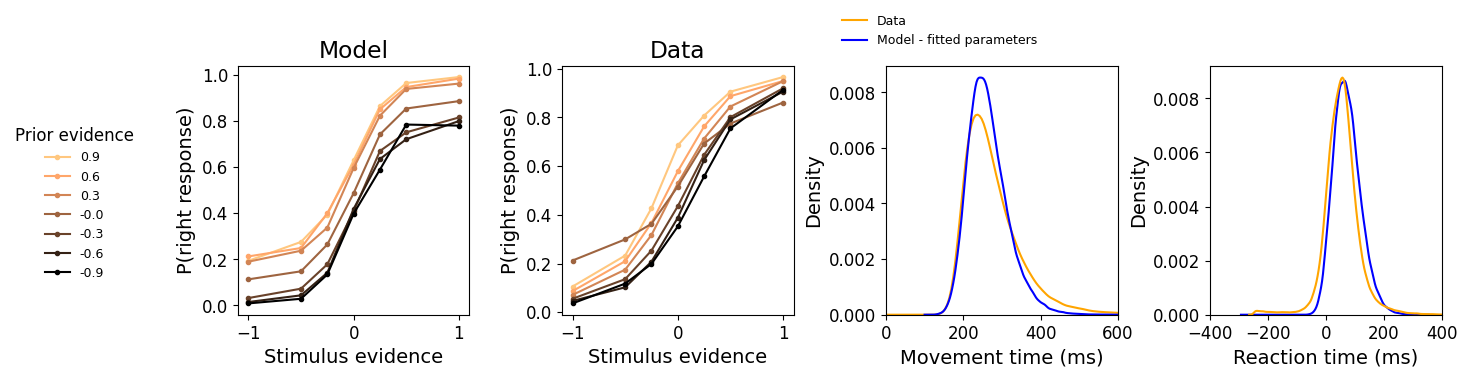

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14, 3))
ax = ax.flatten()
full_psychometric_plot(choice=x[:, 2].detach().numpy(), coh=coh, zt=zt, ax=ax[0], leg=True)  # model psychommetric curves
full_psychometric_plot(choice=choice, coh=coh, zt=zt, ax=ax[1])  # data psychommetric curves
# plot MT
sns.kdeplot(mt*1e3, color='orange', ax=ax[2], label='Data')  # model
sns.kdeplot(x[:,0], color='blue', ax=ax[2], label='Model - fitted parameters')  # data
# plot RT
sns.kdeplot(x[:,1], color='blue', ax=ax[3], label='Model - fitted parameters')  # model
sns.kdeplot(data[:, 4] - 300, color='orange', ax=ax[3], label='Data')  # data (with FB)
# tune panels
ax[0].set_title('Model')
ax[1].set_title('Data')
ax[2].legend(bbox_to_anchor=(0.7, 1.25), fontsize=9, frameon=False)
ax[2].set_xlim(0, 600)
ax[2].set_xlabel('Movement time (ms)')
ax[3].set_xlabel('Reaction time (ms)')
ax[3].set_xlim(-400, 400)
plt.subplots_adjust(top=0.95, bottom=0.12, left=0.09, right=0.95, hspace=0.4, wspace=0.4)

We can see that the fits improved considerably compared to the prior estimates, even though the fit is not perfect. That is because we used only 100k trials (for the results shown in the paper we used 10M).